# Squirrel Classifier

Reference: [FastAI Practical Deep Learning for Coders, Lesson 1](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data)

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ray 1.13.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


In [2]:
# Import dependencies
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from time import sleep
import PIL.Image

## 1. Download images

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('squirrel photos', max_images=1)

Searching for 'squirrel photos'


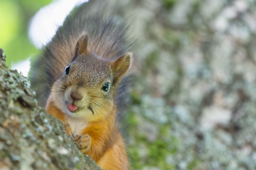

In [5]:
dest = 'squirrel.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'tree photos'


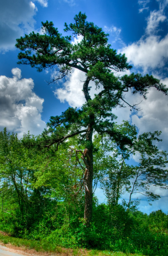

In [6]:
dest = 'tree.jpg'
download_url(search_images('tree photos', max_images=1)[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

In [7]:
searches = 'squirrel','tree'
path = Path('squirrel_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'squirrel photo'
Searching for 'squirrel sun photo'
Searching for 'squirrel shade photo'
Searching for 'tree photo'
Searching for 'tree sun photo'
Searching for 'tree shade photo'


## 2. Model Training

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

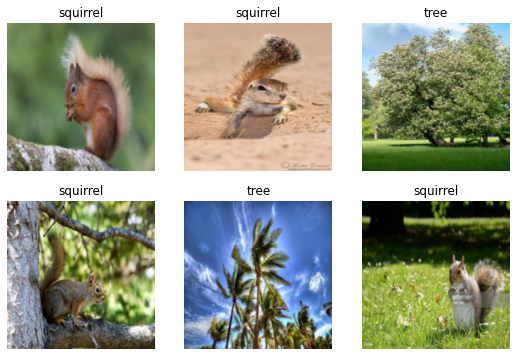

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.935727,0.772538,0.371429,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.115781,0.150965,0.057143,00:15
1,0.073038,0.019410,0.000000,00:16
2,0.050582,0.007033,0.000000,00:23
3,0.044110,0.011986,0.000000,00:15
4,0.037000,0.027555,0.028571,00:16
5,0.034177,0.062810,0.028571,00:15
6,0.028064,0.060157,0.028571,00:14
7,0.023566,0.051607,0.028571,00:15
8,0.022356,0.052193,0.028571,00:15
9,0.019332,0.047907,0.028571,00:14


## 3. Model Inference

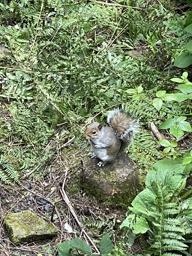

This is a: squirrel.
Probability it's a squirrel: 0.9980


In [11]:
image = 'IMG_6787.png'
dest = f'../input/squirrels/{image}'

is_squirrel,_,probs = learn.predict(PILImage.create(dest))
im = Image.open(dest)
display(im.to_thumb(256,256))

print(f"This is a: {is_squirrel}.")
print(f"Probability it's a squirrel: {probs[0]:.4f}")